# Generation and post-analysis in aids dataset

In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [3]:
%matplotlib inline

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

### Experiment setting - links to data

In [4]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

## Statistical analysis with original data

In [5]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,1,1,1,0,100,169.0,39.0,34
1,287,0,1,2,2,0,90,149.5,15.0,34
2,199,0,1,1,1,0,90,46.0,53.0,48
3,270,0,1,1,2,0,100,54.5,6.0,51
4,276,0,1,1,1,0,100,95.0,7.0,34


In [6]:
aids_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')

In [7]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]

In [8]:
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
aids_control_columns

['time',
 'censor',
 'strat2',
 'sex',
 'raceth',
 'ivdrug',
 'karnof',
 'cd4',
 'priorzdv',
 'age']

### Data loading and Feature analysis treated/control

In [9]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [10]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [11]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"] = 1
df_transformed_control["treatment"] = 0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [12]:
df_transformed_all.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age', 'treatment'],
      dtype='object')

In [13]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,189.0,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,287.0,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,199.0,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,270.0,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,276.0,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


In [14]:
df_transformed_all.shape

(1151, 11)

In [15]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 10


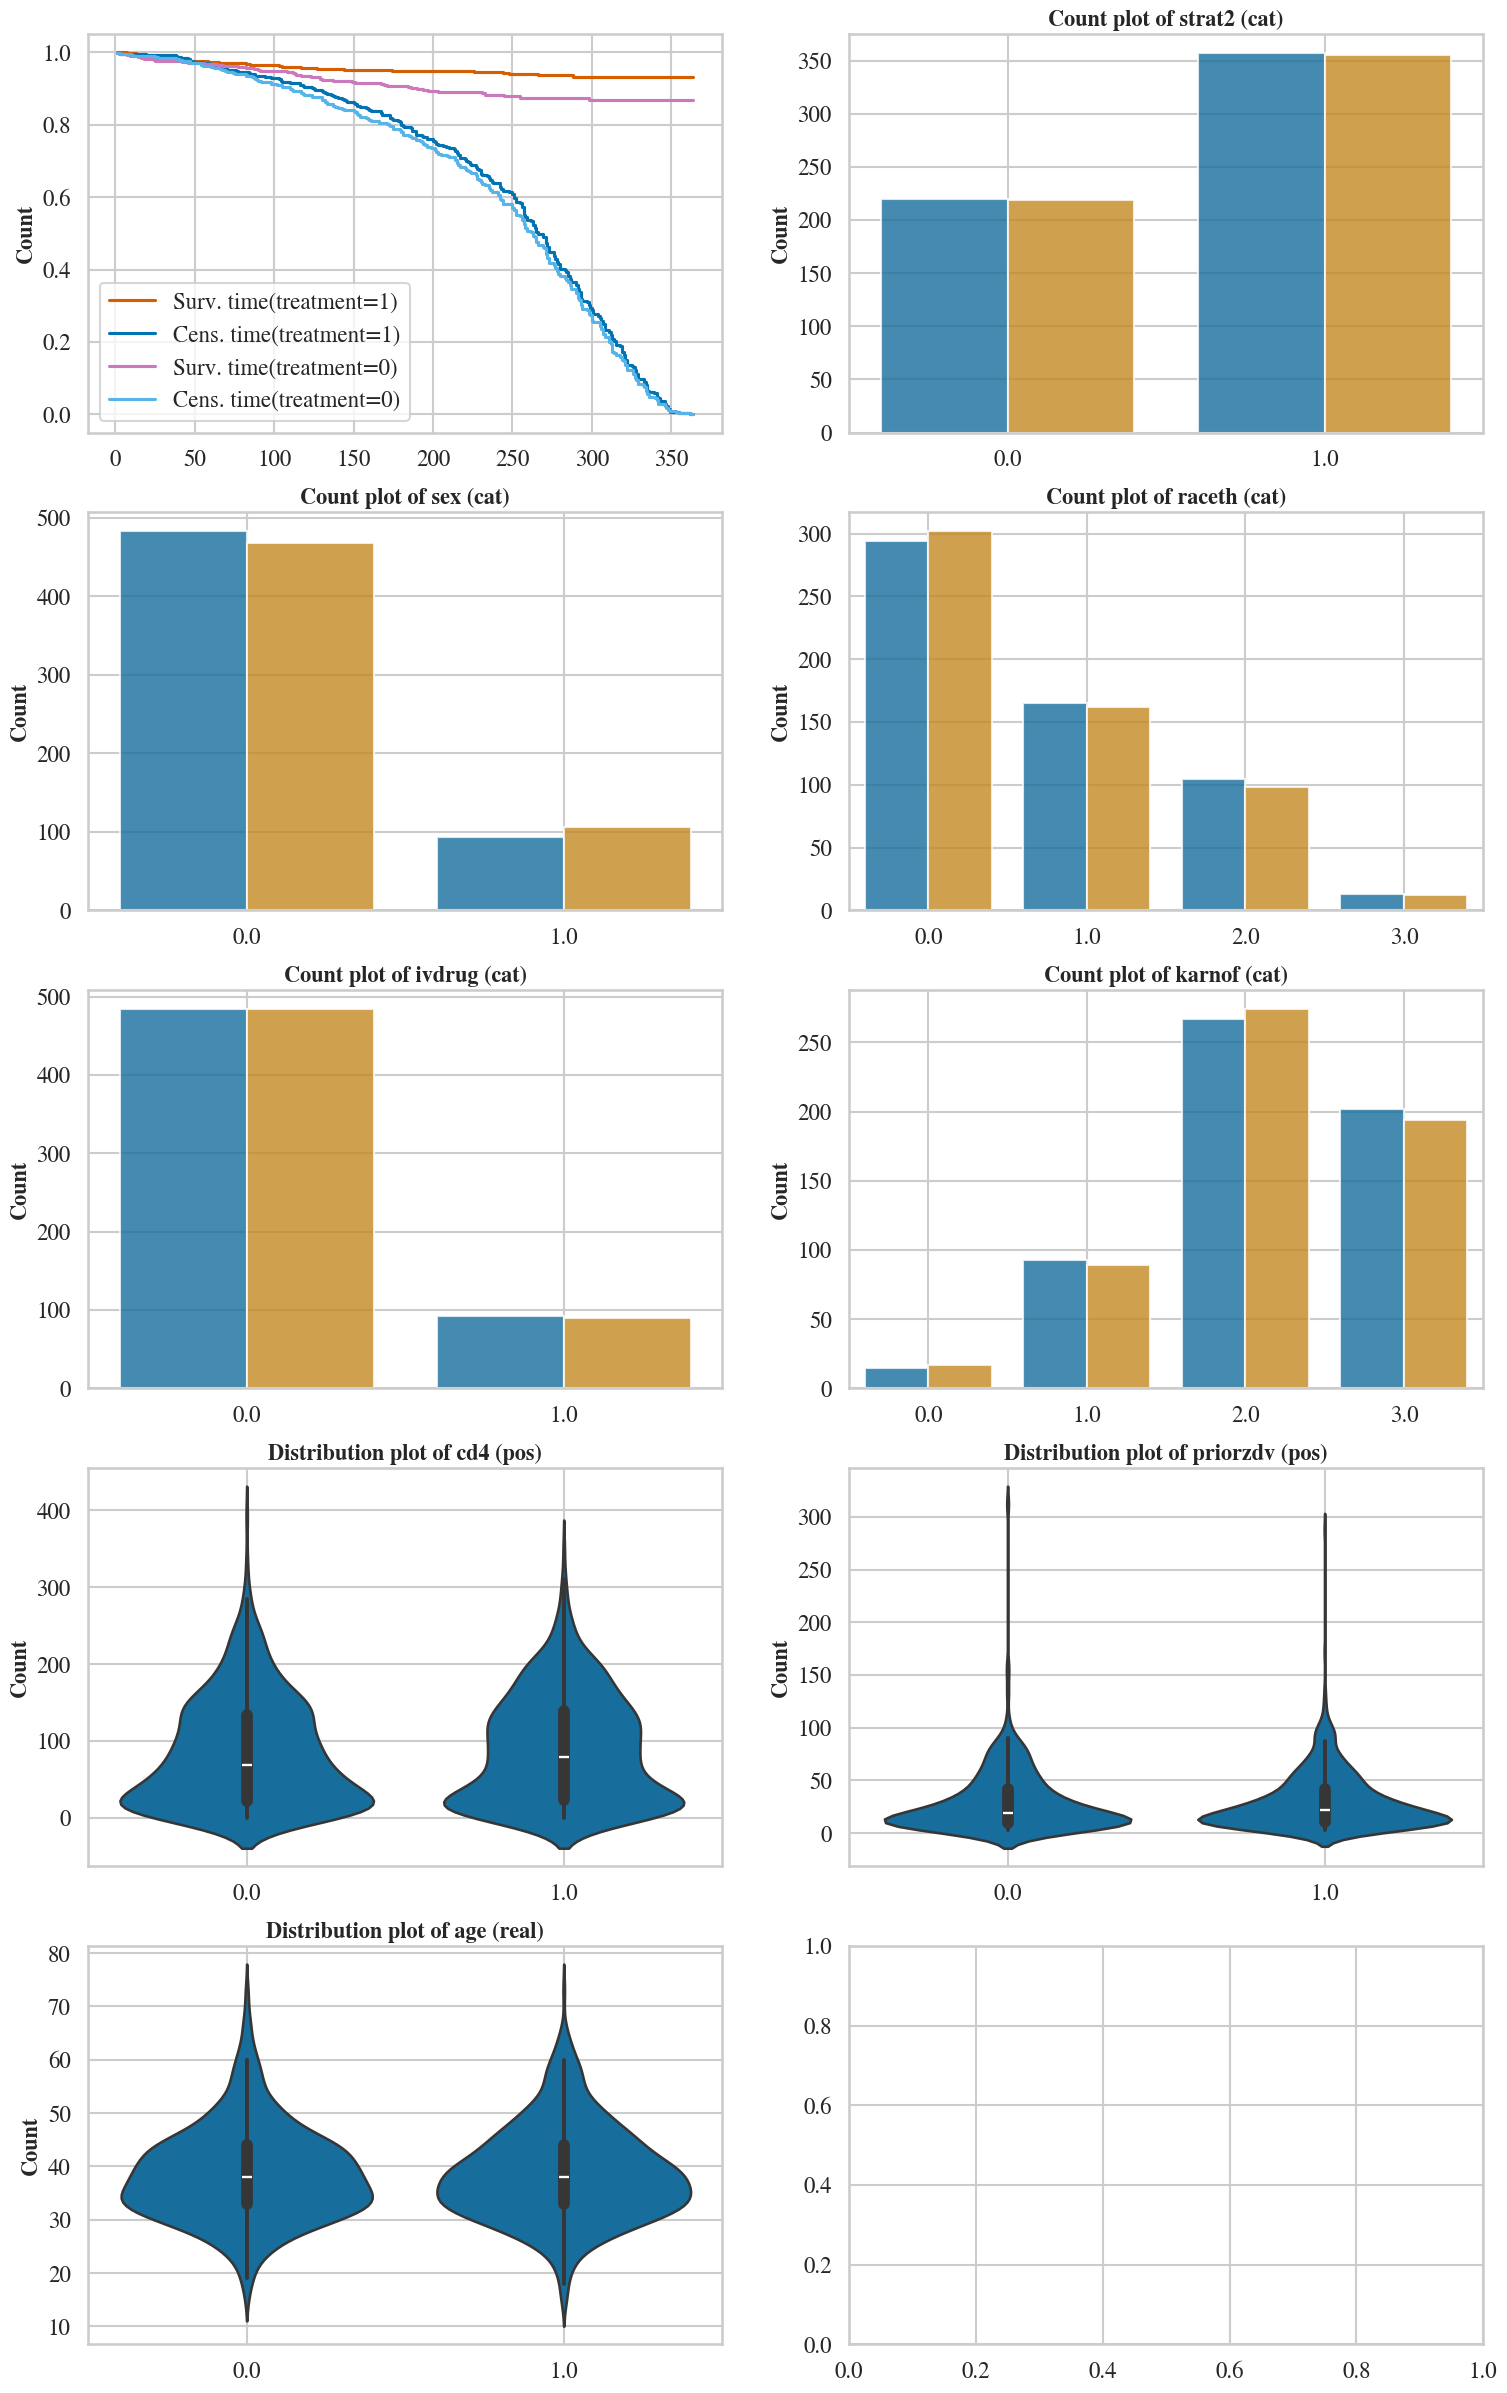

In [16]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [17]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [18]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

## Training SurvGAN

### Experiment setting

In [19]:
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

n_generated_sample = 100

# X = aids_control  #original (lightly preprocessed dataset)
X = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns) #preprocessed dataset

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Model loading

In [20]:
syn_model = Plugins().get("survival_gan") # possibility to change to ['survae', 'survival_ctgan', 'survival_gan', 'survival_nflow']

[2025-04-11T09:33:33.467087+0200][54871][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity_test/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py


### Train model

In [21]:
# Conditioning the GAN on the age and sex of the patients
cond = X[['age', 'sex']]
syn_model.fit(data, cond=cond)

## Unconditional generation
# syn_model.fit(data)

[2025-04-11T09:33:41.010214+0200][54871][CRITICAL] module disabled: /opt/anaconda3/envs/env_synthcity_test/lib/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py
  3%|▎         | 299/10000 [00:19<10:45, 15.02it/s]


## Generated samples from control dataset

In [22]:
est_data_gen_transformed = []
for j in range(n_generated_sample):
    out = syn_model.generate(count=577)
    est_data_gen_transformed.append(out)

In [23]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

In [24]:
#visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
#                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

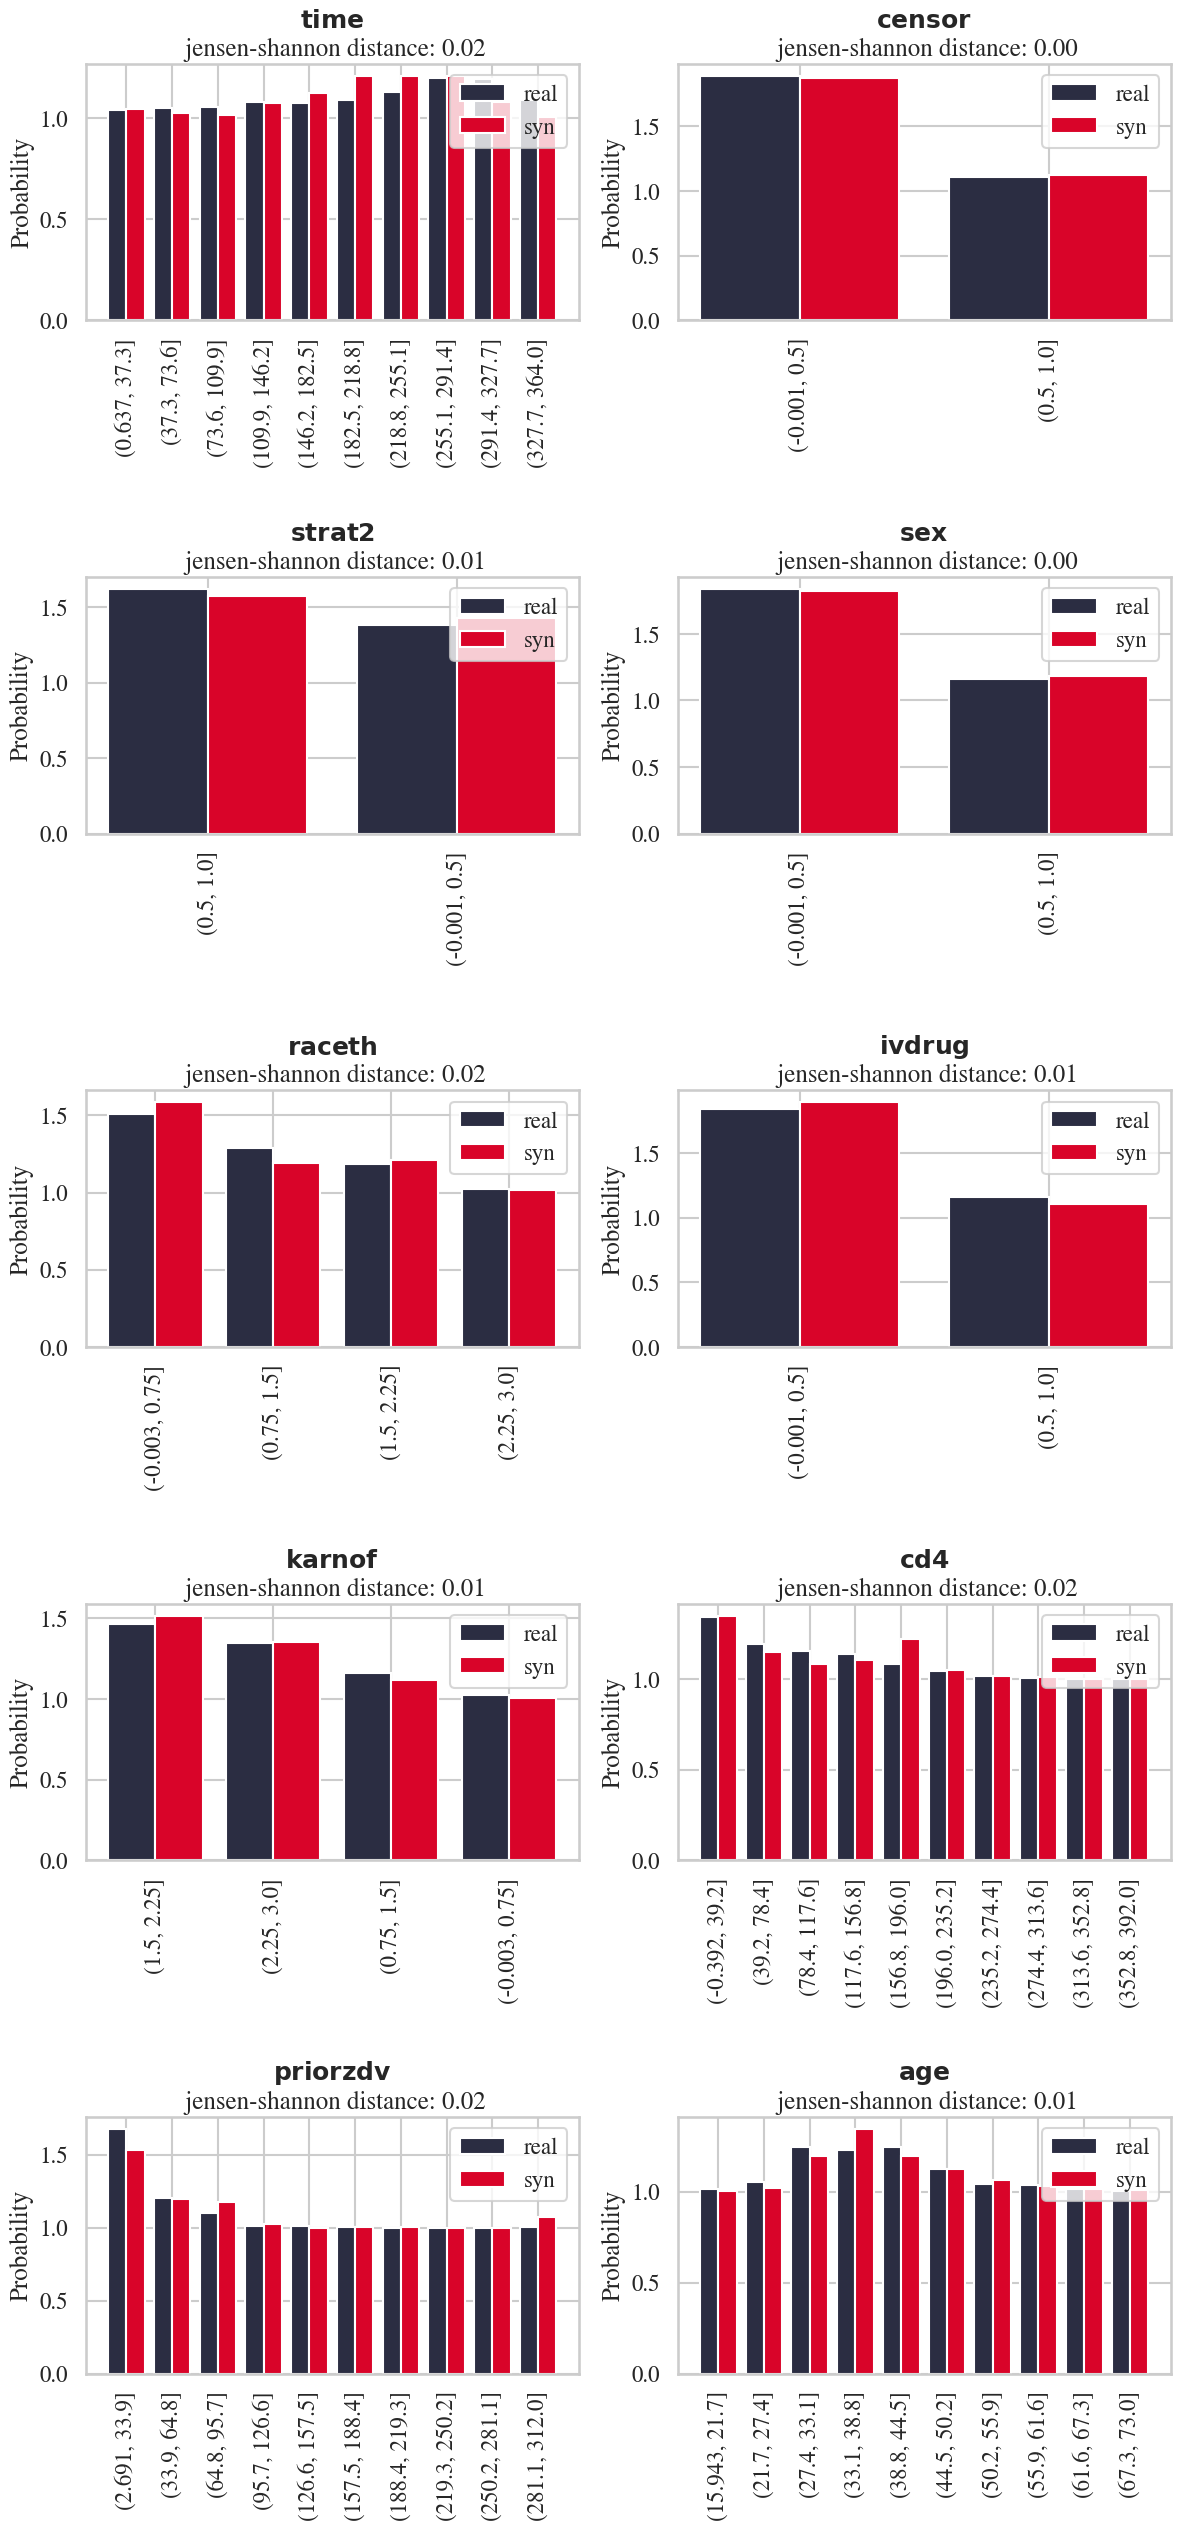

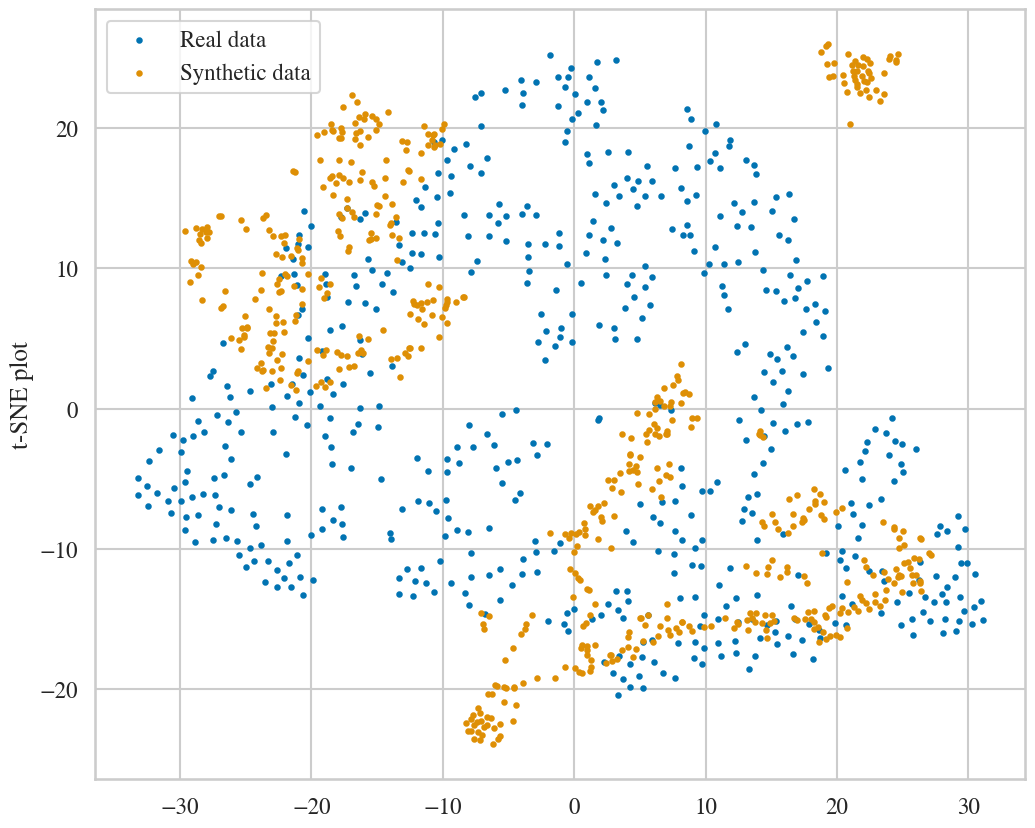

In [25]:
import matplotlib.pyplot as plt

syn_model.plot(plt, data)

plt.show()

### Statistical analysis with simulated vs initial control data

In [26]:
# data_gen_control['treatment'] = 0
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=aids_control_columns)
df_transformed_initial['sample']=1
df_transformed_generated['sample']=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

comparison variable sample 10


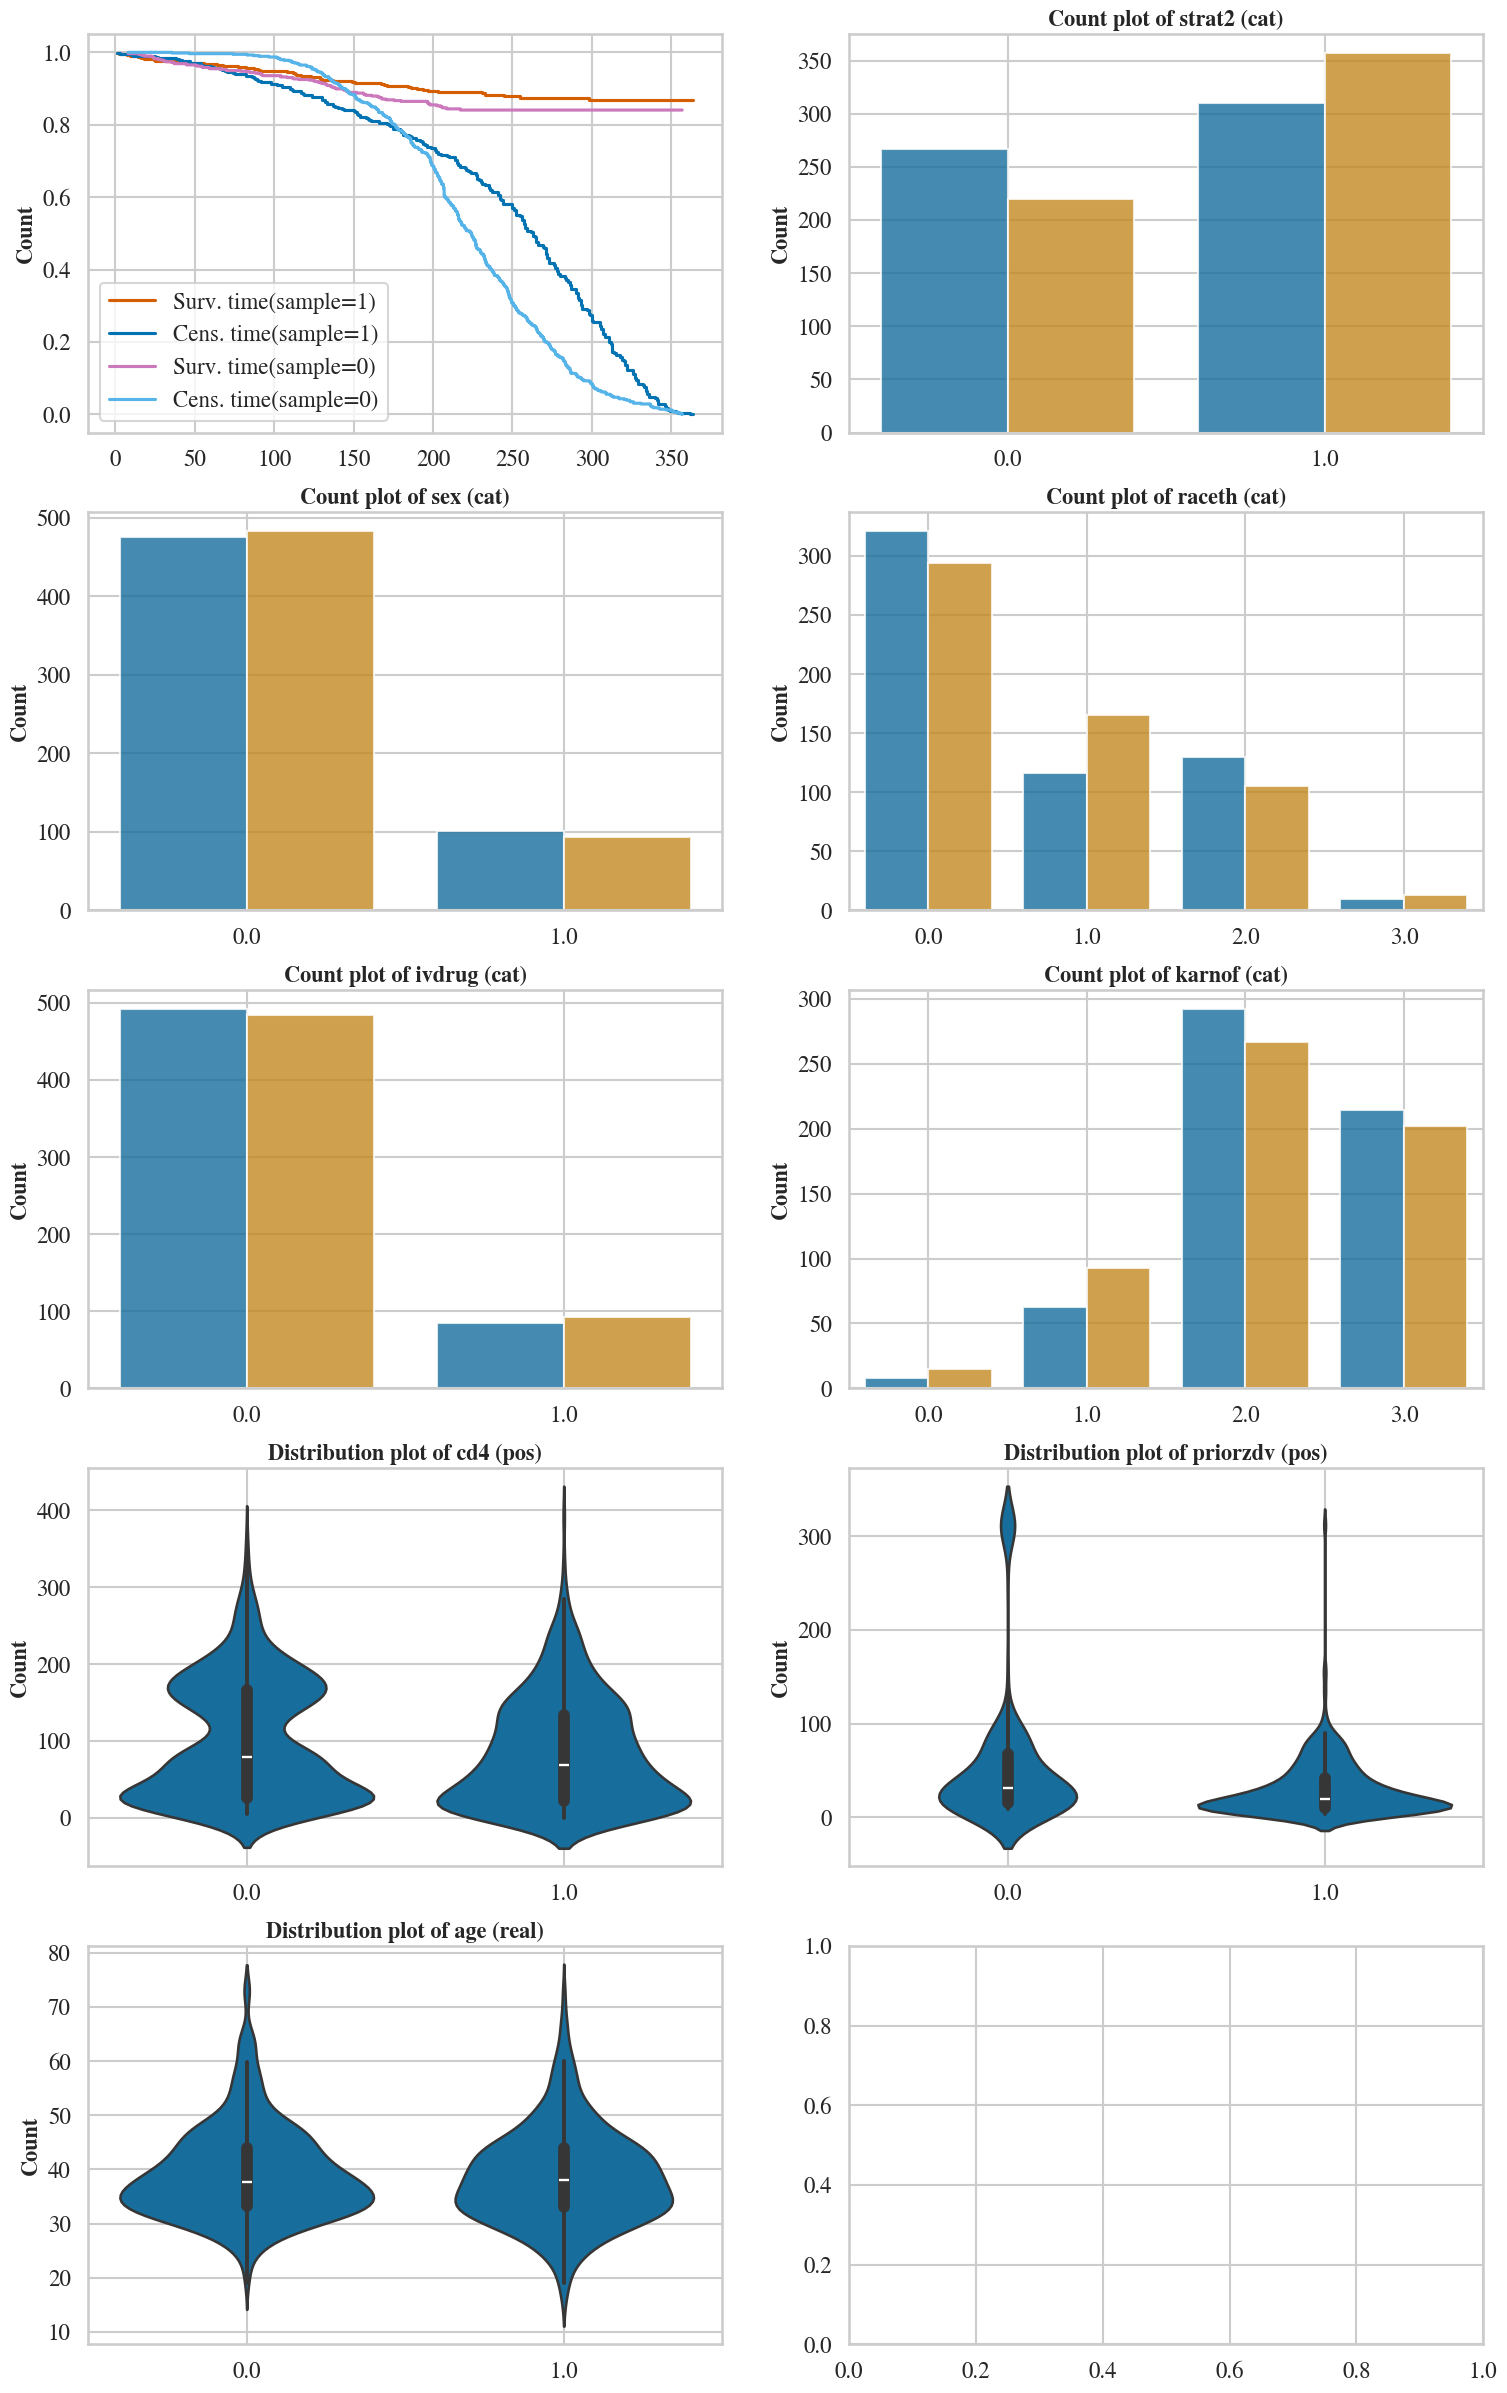

In [27]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(), feat_types_dict_all, feat_comparison_name = 'sample')

In [28]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [29]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  225.6 [160.1,277.0]  209.4 [161.4,252.0]  251.0 [158.0,298.0]  <0.001
censor, n (%)            0.0                            1008 (87.3)           494 (85.6)           514 (89.1)   0.092
                         1.0                             146 (12.7)            83 (14.4)            63 (10.9)        
strat2, n (%)            0.0                             487 (42.2)           267 (46.3)           220 (38.1)   0.006
                         1.0                             667 (57.8)           310 (53.7)           357 (61.9)        
sex, n (%)               0.0                            

### Statistical analysis: generated control x initial treated

In [30]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=aids_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [31]:
#df_transformed_all.head()

In [32]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

In [33]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  231.0 [170.8,282.5]  209.4 [161.4,252.0]  263.0 [187.0,305.0]  <0.001
censor, n (%)            0.0                               1035 (89.9)           494 (85.6)           541 (94.3)  <0.001
                         1.0                                116 (10.1)            83 (14.4)             33 (5.7)        
strat2, n (%)            0.0                                486 (42.2)           267 (46.3)           219 (38.2)   0.006
                         1.0                                665 (57.8)           310 (53.7)           355 (61.8)        
sex, n (%)               0.0    

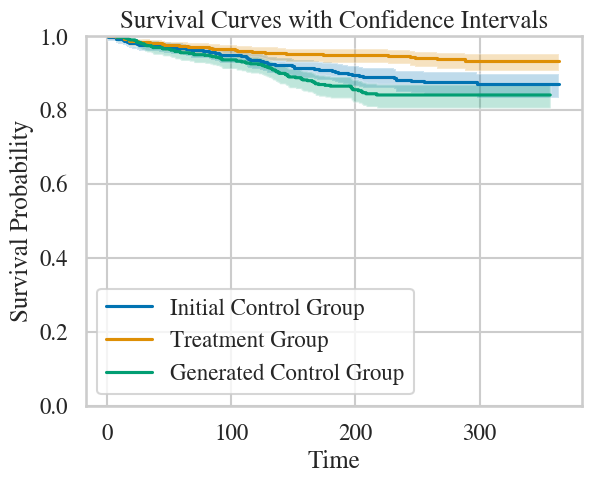

In [34]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [35]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']

Initial Cox model

In [36]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [37]:
number_column_treatment = 6 # in X_initial

In [38]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-1.51111787e-02,  2.03117243e-01, -5.55172796e-01, -1.46215358e-02,
       -7.93512048e-04,  2.40314802e-02, -6.66311702e-01, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

Tests in all generated datasets

In [39]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


In [40]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

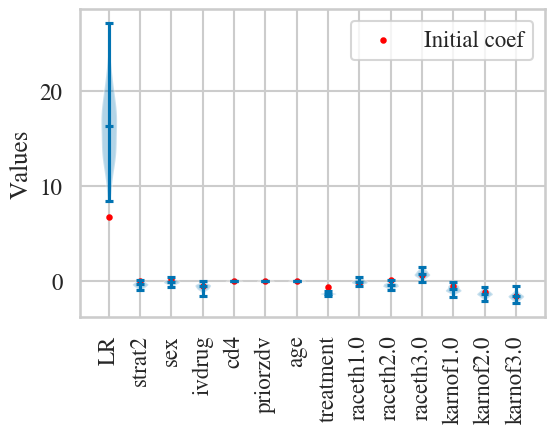

In [41]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

### Log rank test

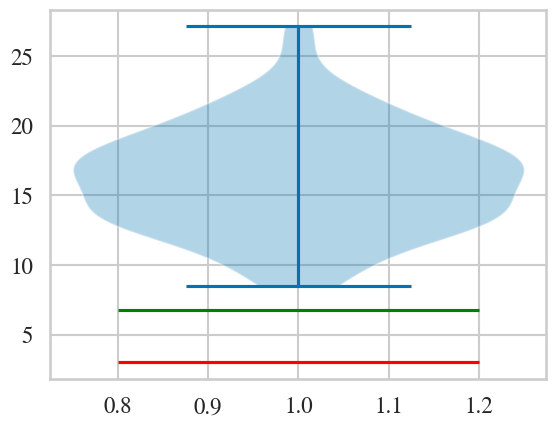

In [42]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

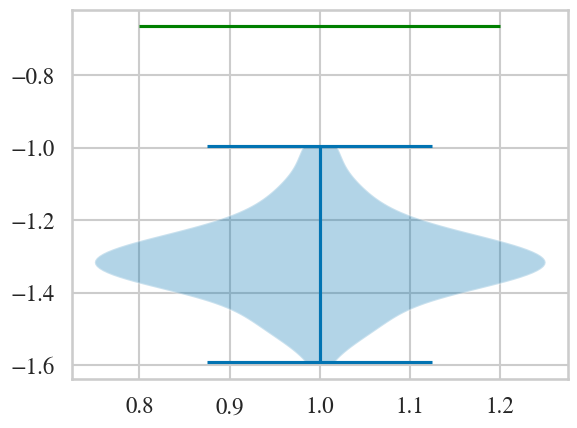

In [43]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

## Stratified w.r. CD4 count analysis

In [44]:
est_data_gen_transformed[0].numpy()

array([[248.04161072,   0.        ,   1.        , ..., 149.09411621,
         12.14740753,  36.02798843],
       [114.5613327 ,   0.        ,   0.        , ...,  14.94940662,
         34.59342957,  46.67449951],
       [299.11999512,   0.        ,   1.        , ...,  16.32821083,
         11.60477638,  33.49872208],
       ...,
       [115.60704803,   1.        ,   0.        , ...,  25.31896591,
         11.423419  ,  38.28899384],
       [302.34213257,   0.        ,   0.        , ...,  23.64951515,
         13.40282536,  32.38827896],
       [233.52497864,   0.        ,   0.        , ...,  21.85654449,
         15.59562492,  38.97927856]], shape=(577, 10))

In [45]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [46]:
cd4_threshold = 50
df_transformed_all_oh_lowcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] <= cd4_threshold]
print(df_transformed_all_oh_lowcd4.shape)
X_initial_lowcd4 = df_transformed_all_oh_lowcd4.to_numpy()[:,2:15]
Y_initial_lowcd4 = Surv.from_arrays(df_transformed_all_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_all_oh_lowcd4.to_numpy()[:,0]) 
df_transformed_all_oh_highcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] > cd4_threshold]
print(df_transformed_all_oh_highcd4.shape)
X_initial_highcd4 = df_transformed_all_oh_highcd4.to_numpy()[:,2:15]
Y_initial_highcd4 = Surv.from_arrays(df_transformed_all_oh_highcd4.to_numpy()[:,1]==1,df_transformed_all_oh_highcd4.to_numpy()[:,0]) 

(459, 15)
(692, 15)


In [47]:
cox_initial_lowcd4 = CoxPHSurvivalAnalysis()
cox_initial_lowcd4.fit(X_initial_lowcd4,Y_initial_lowcd4)
cox_initial_highcd4 = CoxPHSurvivalAnalysis()
cox_initial_highcd4.fit(X_initial_highcd4,Y_initial_highcd4)


CoxPHSurvivalAnalysis()

In [48]:
feat_types_dict_all

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'}]

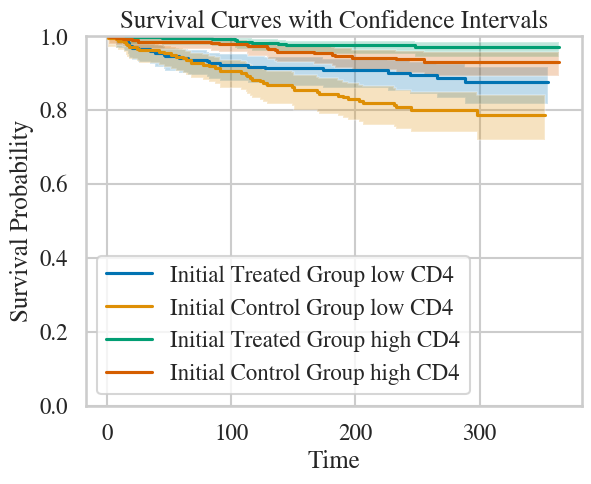

In [49]:
time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, conf_int_initial_lowcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, conf_int_initial_lowcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_highcd4_T, survival_prob_initial_highcd4_T, conf_int_initial_highcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


time_initial_highcd4_C, survival_prob_initial_highcd4_C, conf_int_initial_highcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

plt.step(time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, where="post", label="Initial Treated Group low CD4")
plt.fill_between(time_initial_lowcd4_T, conf_int_initial_lowcd4_T[0], conf_int_initial_lowcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, where="post", label="Initial Control Group low CD4")
plt.fill_between(time_initial_lowcd4_C, conf_int_initial_lowcd4_C[0], conf_int_initial_lowcd4_C[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_T, survival_prob_initial_highcd4_T, where="post", label="Initial Treated Group high CD4")
plt.fill_between(time_initial_highcd4_T, conf_int_initial_highcd4_T[0], conf_int_initial_highcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_C, survival_prob_initial_highcd4_C, where="post", label="Initial Control Group high CD4")
plt.fill_between(time_initial_highcd4_C, conf_int_initial_highcd4_C[0], conf_int_initial_highcd4_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

In [50]:
compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])

(np.float64(5.535873093721627), np.float64(0.018630467405504756))

In [51]:
compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])

(np.float64(4.395519026726351), np.float64(0.03603349014270788))

In [52]:
coef_treat_lowcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
coef_treat_highcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    df_transformed_T_Cgen_oh_lowcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] <= cd4_threshold]
    X_gen_lowcd4 = df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,2:15]
    Y_gen_lowcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,0]) 
    df_transformed_T_Cgen_oh_highcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] > cd4_threshold]
    X_gen_highcd4 = df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,2:15]
    Y_gen_highcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,0]) 
    
    coef_treat_lowcd4[i,0] = -np.log(compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])[1])
    cox_generated_lowcd4 = CoxPHSurvivalAnalysis()
    cox_generated_lowcd4.fit(X_gen_lowcd4,Y_gen_lowcd4)
    coef_treat_lowcd4[i,1:] = cox_generated_lowcd4.coef_[:]

    coef_treat_highcd4[i,0] = -np.log(compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])[1])
    cox_generated_highcd4 = CoxPHSurvivalAnalysis()
    cox_generated_highcd4.fit(X_gen_highcd4,Y_gen_highcd4)
    coef_treat_highcd4[i,1:] = cox_generated_highcd4.coef_[:]


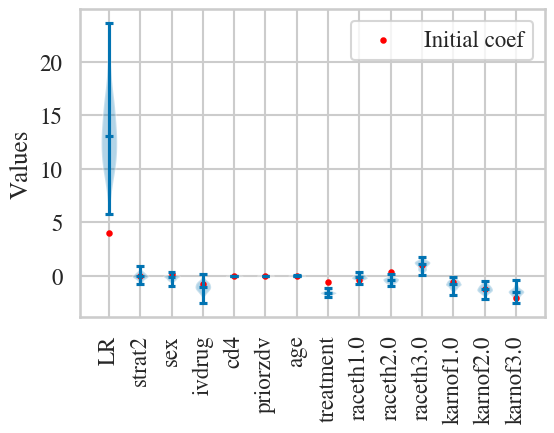

In [53]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_lowcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_lowcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_lowcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_lowcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

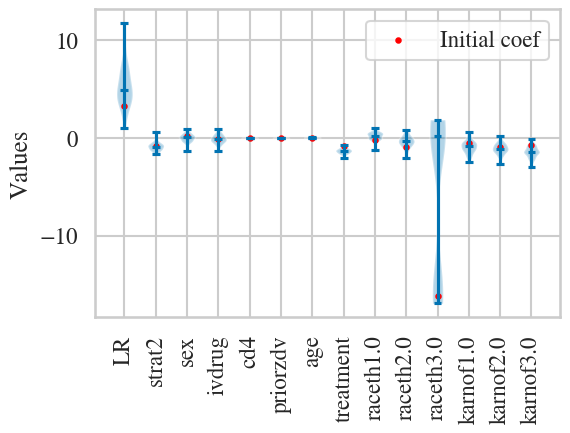

In [54]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_highcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_highcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_highcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_highcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [55]:
compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])

(np.float64(11.125423491943868), np.float64(0.000851524320189064))

# Metrics from synthcity

All the metrics available in synthcity are detailled here: [https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics](https://github.com/vanderschaarlab/synthcity/tree/main#zap-evaluation-metrics) 

In [56]:
from synthcity.metrics.eval import Metrics

Metrics().list()

{'sanity': ['data_mismatch',
  'common_rows_proportion',
  'nearest_syn_neighbor_distance',
  'close_values_probability',
  'distant_values_probability'],
 'stats': ['jensenshannon_dist',
  'chi_squared_test',
  'inv_kl_divergence',
  'ks_test',
  'max_mean_discrepancy',
  'wasserstein_dist',
  'prdc',
  'alpha_precision',
  'survival_km_distance',
  'fid'],
 'performance': ['linear_model',
  'mlp',
  'xgb',
  'linear_model_augmentation',
  'mlp_augmentation',
  'xgb_augmentation',
  'feat_rank_distance'],
 'detection': ['detection_xgb',
  'detection_mlp',
  'detection_gmm',
  'detection_linear'],
 'privacy': ['delta-presence',
  'k-anonymization',
  'k-map',
  'distinct l-diversity',
  'identifiability_score',
  'DomiasMIA_BNAF',
  'DomiasMIA_KDE',
  'DomiasMIA_prior']}

In [57]:
list_df_transformed_generated = []
for j in range(n_generated_sample):
    df_transformed_generated_j = pd.DataFrame(est_data_gen_transformed[j].numpy(), columns=aids_control_columns)
    df_transformed_generated_j['treatment'] = 0
    list_df_transformed_generated.append(df_transformed_generated_j)

#### Comparison of one generated dataset with the initial one

In [58]:
X_gt = SurvivalAnalysisDataLoader(
    df_transformed_initial,
    target_column="censor",
    time_to_event_column="time",
)

X_syn = SurvivalAnalysisDataLoader(
    list_df_transformed_generated[0],
    target_column="censor",
    time_to_event_column="time",
)

scores = Metrics().evaluate(X_gt=X_gt, # can be dataloaders or dataframes
                            X_syn=X_syn, 
                            reduction='mean', # default mean
                            n_histogram_bins=10, # default 10
                            metrics=None, # all metrics
                            task_type='survival_analysis', 
                            use_cache=True)

In [59]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

scores

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.127660,0.127660,0.127660,0.0,0.127660,0.0,1,0,0.00,minimize
sanity.close_values_probability.score,0.864818,0.864818,0.864818,0.0,0.864818,0.0,1,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.001733,0.001733,0.0,0.001733,0.0,1,0,0.00,minimize
stats.max_mean_discrepancy.joint,0.003475,0.003475,0.003475,0.0,0.003475,0.0,1,0,0.01,minimize
stats.wasserstein_dist.joint,0.070727,0.070727,0.070727,0.0,0.070727,0.0,1,0,0.06,minimize
stats.prdc.precision,0.993068,0.993068,0.993068,0.0,0.993068,0.0,1,0,0.01,maximize
stats.prdc.recall,0.911612,0.911612,0.911612,0.0,0.911612,0.0,1,0,0.01,maximize
stats.prdc.density,1.034315,1.034315,1.034315,0.0,1.034315,0.0,1,0,0.01,maximize
stats.prdc.coverage,0.819757,0.819757,0.819757,0.0,0.819757,0.0,1,0,0.01,maximize


#### Comparison of the 'n_generated_samples' synthetic datasets with the initial one

In [60]:
# Un peu long de run toutes les métriques sur les 100 échantillons générés donc je ne fais que sur 
# les 20 premiers ici (mais à terme peut être que toutes les métriques ne sont pas nécessaires).

In [61]:
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

X_gt = SurvivalAnalysisDataLoader(
    df_transformed_initial,
    target_column="censor",
    time_to_event_column="time",
    )

scores = ScoreEvaluator()
for j in range(20):
# for j in range(n_generated_sample):
    enable_reproducible_results(j)
    clear_cache()

    X_syn = SurvivalAnalysisDataLoader(
        list_df_transformed_generated[j],
        target_column="censor",
        time_to_event_column="time",
        )

    evaluation = Metrics().evaluate(X_gt=X_gt, # can be dataloaders or dataframes
                        X_syn=X_syn, 
                        reduction='mean', # default mean
                        n_histogram_bins=10, # default 10
                        metrics=None, # all metrics
                        task_type='survival_analysis', 
                        use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(
            key,
            mean_score[key],
            errors[key],
            duration[key],
            direction[key],
        )

out = scores.to_dataframe()

In [62]:
out

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20,0,0.00,minimize
sanity.nearest_syn_neighbor_distance.mean,0.116270,0.159893,0.139705,0.012418,0.142165,0.018755,20,0,0.00,minimize
sanity.close_values_probability.score,0.755633,0.880416,0.822877,0.039671,0.823224,0.061092,20,0,0.00,maximize
sanity.distant_values_probability.score,0.001733,0.005199,0.003120,0.001040,0.003466,0.001733,20,0,0.00,minimize
stats.max_mean_discrepancy.joint,0.003467,0.003490,0.003474,0.000005,0.003473,0.000003,20,0,0.01,minimize
stats.wasserstein_dist.joint,0.062835,0.082844,0.072406,0.004918,0.073332,0.006251,20,0,0.05,minimize
stats.prdc.precision,0.993068,1.000000,0.996360,0.002116,0.996534,0.003466,20,0,0.01,maximize
stats.prdc.recall,0.871750,0.923744,0.894454,0.015432,0.894281,0.020364,20,0,0.01,maximize
stats.prdc.density,1.033276,1.097747,1.059515,0.017782,1.056672,0.017331,20,0,0.01,maximize
stats.prdc.coverage,0.748700,0.844021,0.801906,0.022980,0.800693,0.026430,20,0,0.01,maximize
